# PSUPR / PRMLS CA2

### Team
Kenneth Goh Chia Wei : A0198544N  
Tan Heng Han : A0198502B  
Raymond Ng Boon Cheong : A0198543R

In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import pprint
import lxml
import re
import os
import glob
import gensim
import time
from collections import Counter

from bs4 import BeautifulSoup
import nltk
# nltk.download('stopwords')
from nltk.tokenize import WordPunctTokenizer
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

## Create a function for cleaning up tweets
Reference: https://towardsdatascience.com/another-twitter-sentiment-analysis-bb5b01ebad90

In [3]:
# Init WordPunctTokenizer
tok = WordPunctTokenizer()
# create reg expression
pat1 = r'@[A-Za-z0-9]+'
pat2 = r'https?://[A-Za-z0-9./]+'
combined_pat = r'|'.join((pat1, pat2))

def tweet_cleaner(text):
    # Use beautiful soup to decode html to text
    soup = BeautifulSoup(text, 'lxml')
    souped = soup.get_text()
    # strip text using regular expression
    stripped = re.sub(combined_pat, '', souped)
    try:
        clean = stripped.decode("utf-8-sig").replace(u"\ufffd", "?")
    except:
        clean = stripped
    # strip to letters only
    letters_only = re.sub("[^a-zA-Z]", " ", clean)
    # remove retweets handle
    removed_rt = re.sub('RT ','',letters_only)
    # set to lower case for all characters
    lower_case = removed_rt.lower()
    # During the letters_only process two lines above, it has created unnecessay white spaces,
    # I will tokenize and join together to remove unneccessary white spaces
    words = tok.tokenize(lower_case)
    return (" ".join(words)).strip()

In [4]:
dataset_directories = {
    'happy': '..\dataset\happy',
    'sad': '..\dataset\sad',
    'angry': '..\dataset\\angry',
}

def getTweetsFromCSV(directory):  
    files = glob.glob(directory + '\*.csv')
    dfs = [pd.read_csv(f) for f in files]
    dfs_combined = pd.concat(dfs, ignore_index=True)
    return dfs_combined

dfs = []
for directory in dataset_directories:
    all_dfs = getTweetsFromCSV(dataset_directories[directory])
    all_dfs['label'] = directory
    dfs.append(all_dfs)

df_col = dfs[0].columns
final = pd.concat(dfs, ignore_index=True)
df = pd.DataFrame(final, columns=df_col)

In [5]:
df.head()

,text,weekday,month,day,hour,has_hashtag,has_url,fav_count,is_reply,retweet_count,followers,following,user,screen_name,label
0,CRUSH GAME: Describe your crush\n\n1. slightly...,Thu,Sep,12,13,0,1,0,0,0,39,100,+,melliflcus,happy
1,RT @Emolclause: #BREAKING:Now we find out that...,Thu,Sep,12,13,1,0,0,0,157,280,605,Kathleen A. English,kenglishesq1,happy
2,@susie_meister Bless your heart! The neighbor ...,Thu,Sep,12,13,0,1,1,1,0,415,868,Gabrielle,DGCBcardiac96,happy
3,RT @ajimatanrareje: Wow!!! Somethings are bett...,Thu,Sep,12,13,1,1,0,0,1,122,281,Foluso John Gbadebo.,jfoluso,happy
4,@realDonaldTrump Mexico. Wall. Pay. Didn't kno...,Thu,Sep,12,13,0,1,0,1,0,44,82,Paul Gordon,NoJob1263,happy


In [6]:
text = df['text']
label = df['label']
text.head()

0    CRUSH GAME: Describe your crush\n\n1. slightly...
1    RT @Emolclause: #BREAKING:Now we find out that...
2    @susie_meister Bless your heart! The neighbor ...
3    RT @ajimatanrareje: Wow!!! Somethings are bett...
4    @realDonaldTrump Mexico. Wall. Pay. Didn't kno...
Name: text, dtype: object

In [7]:
label.head()

0    happy
1    happy
2    happy
3    happy
4    happy
Name: label, dtype: object

### Clean up all tweets

In [8]:
cleaned_tweets = []
for tweet in text:
    cleaned_tweets.append(tweet_cleaner(tweet))
print((cleaned_tweets[:5]))
print(f'Tweets total: {len(cleaned_tweets)}')

['crush game describe your crush slightly taller older floof noooo nooo school', 'breaking now we find out that pence needlessly cost taxpayers shuttling back and forth from dunlin to trump', 'meister bless your heart the neighbor had to sell his house and move because of all the money his stupidity', 'wow somethings are better explained visually sad', 'mexico wall pay didn t know the armed forces budget was in pesos since they ve been ordered to']
Tweets total: 16918


### Join back to a single DataFrame and remove duplicated tweets

In [9]:
finalDF = pd.DataFrame({'text': cleaned_tweets, 'label': label})
finalDF.drop_duplicates(subset='text', inplace=True, keep='first')

In [10]:
finalDF.shape

(7281, 2)

In [11]:
finalDF.head()

,text,label
0,crush game describe your crush slightly taller...,happy
1,breaking now we find out that pence needlessly...,happy
2,meister bless your heart the neighbor had to s...,happy
3,wow somethings are better explained visually sad,happy
4,mexico wall pay didn t know the armed forces b...,happy


### Display label distributions

Text(0.5, 1.0, 'Tweets Label Distro')

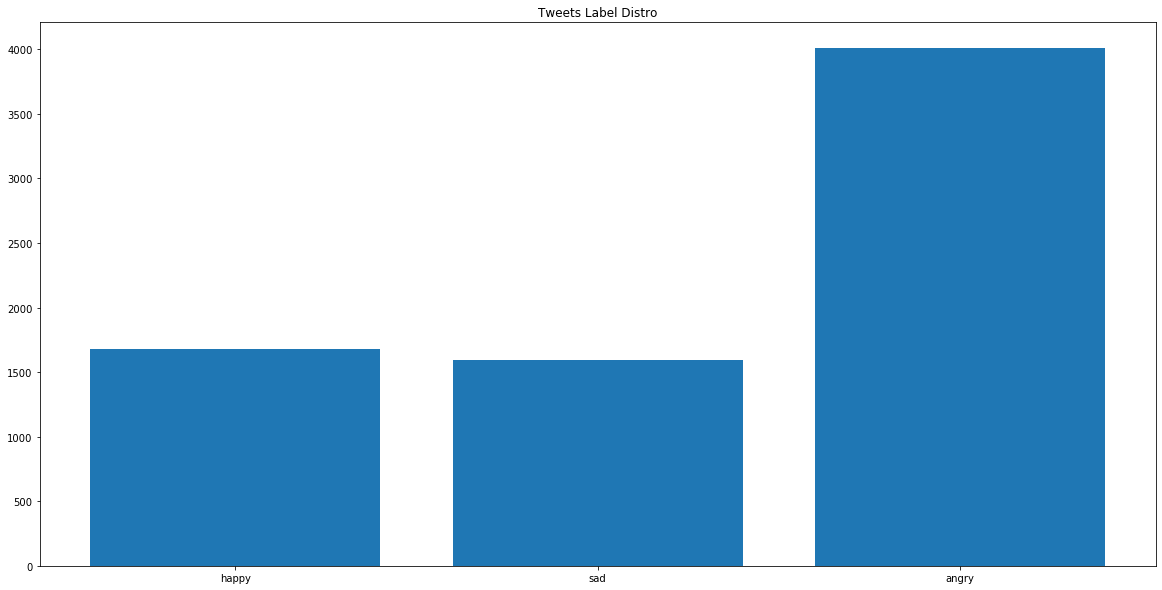

In [12]:
label_count = Counter(finalDF.label)

plt.figure(figsize=(20, 10))
plt.bar(label_count.keys(), label_count.values())
plt.title('Tweets Label Distro')

### Preprocess Dataset

In [22]:
stop_words = stopwords.words('english')
stemmer = SnowballStemmer('english')

In [25]:
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"
def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [26]:
%%time
finalDF.text = finalDF.text.apply(lambda x: preprocess(x))

Wall time: 299 ms


### Train, Test set split

In [31]:
# X_train, X_test, y_train, y_test = train_test_split(finalDF.text, finalDF.label, test_size=0.2, random_state=42)
X_train, X_test = train_test_split(finalDF, test_size=0.2, random_state=42)

In [32]:
X_train.head()

,text,label
12154,oh angry,angry
11980,chicagoans angry da matter,angry
14282,another icon commission cute doggo time intere...,angry
13339,resist beverage w rcsefl peering soul know rub...,angry
11209,better buddhist jenny justice poetry relations...,angry


In [33]:
y_train.head()

12154    angry
11980    angry
14282    angry
13339    angry
11209    angry
Name: label, dtype: object

In [34]:
%%time
documents = [_text.split() for _text in X_train.text]

Wall time: 8.96 ms


In [35]:
w2v_model = gensim.models.word2vec.Word2Vec(size=300,
                                            window=7,
                                           min_count=10,
                                           workers=8)

In [36]:
%%time
w2v_model.build_vocab(documents)

Wall time: 335 ms


In [37]:
words = w2v_model.wv.vocab.keys()
vocab_size=len(words)
print("Vocab size:", vocab_size)

Vocab size: 959


In [38]:
%%time
w2v_model.train(documents, total_examples=len(documents), epochs=32)

Wall time: 1.5 s


(828917, 1763648)

In [39]:
w2v_model.most_similar("love")

D:\Anaconda3\envs\prmlsca2\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('quotes', 0.890272855758667),
 ('way', 0.8632746338844299),
 ('poetry', 0.8371262550354004),
 ('quote', 0.8270756006240845),
 ('empty', 0.8200686573982239),
 ('twice', 0.8143486976623535),
 ('act', 0.8095093965530396),
 ('joy', 0.8064761161804199),
 ('soul', 0.7967037558555603),
 ('free', 0.7908342480659485)]

### Tokenize Text

In [43]:
%%time
tokenizer = Tokenizer()
tokenizer.fit_on_texts(finalDF.text)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 15762
Wall time: 276 ms


In [45]:
%%time
x_train = pad_sequences(tokenizer.texts_to_sequences(finalDF.text), maxlen=300)
x_test = pad_sequences(tokenizer.texts_to_sequences(finalDF.text), maxlen=300)

Wall time: 291 ms


In [47]:
labels = finalDF.label.unique().tolist()
labels

['happy', 'sad', 'angry']

In [51]:
encoder = LabelEncoder()
encoder.fit(finalDF.label.tolist())

y_train = encoder.transform(finalDF.label.tolist())
y_test = encoder.transform(finalDF.label.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (7281, 1)
y_test (7281, 1)


In [53]:
embedding_matrix = np.zeros((vocab_size, 300))
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(15762, 300)


In [54]:
embedding_layer = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=300, trainable=False)

In [55]:
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 300, 300)          4728600   
_________________________________________________________________
dropout_1 (Dropout)          (None, 300, 300)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 4,889,101
Trainable params: 160,501
Non-trainable params: 4,728,600
_________________________________________________________________


In [56]:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [57]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)]

In [59]:
%%time
history = model.fit(x_train, y_train,
                    batch_size=32,
                    epochs=8,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

Train on 6552 samples, validate on 729 samples
Epoch 1/8
6552/6552 [==============================] - 214s 33ms/step - loss: -0.7586 - acc: 0.4629 - val_loss: 2.1174 - val_acc: 0.5789
Epoch 2/8
6552/6552 [==============================] - 214s 33ms/step - loss: -1.4328 - acc: 0.5307 - val_loss: 1.6303 - val_acc: 0.6145
Epoch 3/8
6552/6552 [==============================] - 213s 33ms/step - loss: -1.6188 - acc: 0.5520 - val_loss: 2.1325 - val_acc: 0.6255
Epoch 4/8
6552/6552 [==============================] - 214s 33ms/step - loss: -1.7100 - acc: 0.5495 - val_loss: 1.1675 - val_acc: 0.7407
Epoch 5/8
6552/6552 [==============================] - 185s 28ms/step - loss: -1.7668 - acc: 0.5539 - val_loss: 1.8924 - val_acc: 0.5693
Epoch 6/8
6552/6552 [==============================] - 101s 15ms/step - loss: -1.8154 - acc: 0.5632 - val_loss: 1.4972 - val_acc: 0.6680
Epoch 7/8
6552/6552 [==============================] - 101s 15ms/step - loss: -1.8440 - acc: 0.5665 - val_loss: 2.2840 - val_acc: 0

In [60]:
%%time
score = model.evaluate(x_test, y_test, batch_size=32)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

7281/7281 [==============================] - 47s 6ms/step

ACCURACY: 0.5776679028179141
LOSS: -1.664263288720331
Wall time: 47.2 s


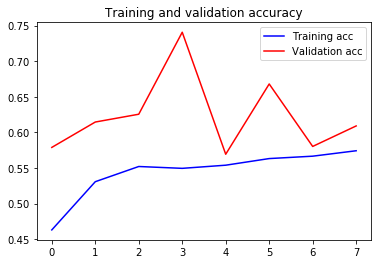

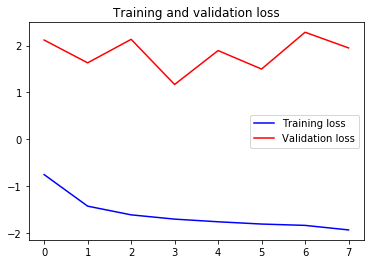

In [61]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

In [ ]:
def decode_sentiment(score, include_neutral=True):
    if include_neutral:        
        label = NEUTRAL
        if score <= SENTIMENT_THRESHOLDS[0]:
            label = NEGATIVE
        elif score >= SENTIMENT_THRESHOLDS[1]:
            label = POSITIVE

        return label
    else:
        return NEGATIVE if score < 0.5 else POSITIVE

In [ ]:
def predict(text, include_neutral=True):
    start_at = time.time()
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)
    # Predict
    score = model.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(score, include_neutral=include_neutral)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at}  

In [ ]:
predict()

In [ ]:
%%time
y_pred_1d = []
y_test_1d = list(df_test.target)
scores = model.predict(x_test, verbose=1, batch_size=8000)
y_pred_1d = [decode_sentiment(score, include_neutral=False) for score in scores]

In [ ]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

In [ ]:
%%time

cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, classes=df_train.target.unique(), title="Confusion matrix")
plt.show()

In [ ]:
print(classification_report(y_test_1d, y_pred_1d))

In [ ]:
accuracy_score(y_test_1d, y_pred_1d)